# Notebook 3: Classification Using Machine Learning

In this notebook, we will use a classical machine learning method to classify the astronomical data saved in the previous notebook.

---

### Reading the data

First, we’ll load the saved image and label data from the NumPy files.

In [1]:
import numpy as np  # Importing NumPy for numerical operations and array handling

# Load the images and labels back from the saved NumPy files
train_images = np.load('train_images.npy')  # Load image training data
val_images = np.load('val_images.npy')      # Load image validation data
train_labels = np.load('train_labels.npy')  # Load label training data
val_labels = np.load('val_labels.npy')      # Load label validation data

print("Data loaded successfully from NumPy files.")

Data loaded successfully from NumPy files.


In [2]:
print(train_images.shape)

(12948, 512, 512, 3)


In [3]:
val_labels.shape

(3237,)

---

## Pre-processing

Now, we will further pre-process the trainig images to simplify the data.

### Normalisation

In [4]:
# Step 1: Normalize the training data

# Scaling pixel values to be between 0 and 1
train_images_normalized = train_images.astype('float32') / 255.0

### Grayscaling

In [5]:
#Step 2: Convert images to grayscale, transforming them from RGB (3 channels) to a single channel (grayscale).

from skimage.color import rgb2gray

# Apply grayscale conversion to each image
train_images_gray = np.array([rgb2gray(image) for image in train_images_normalized])

### Downscaling

In [6]:
# Step 3: Downscale images to 64x64 pixels from 512x512

from skimage.transform import resize

# Resize images to 64x64 pixels
train_images_resized = np.array([resize(image, (64, 64), anti_aliasing=True) for image in train_images_gray])

### Now, Visualizing the 5 classes after pre-processing

In [7]:
print(train_labels)

[4 3 3 ... 0 4 3]


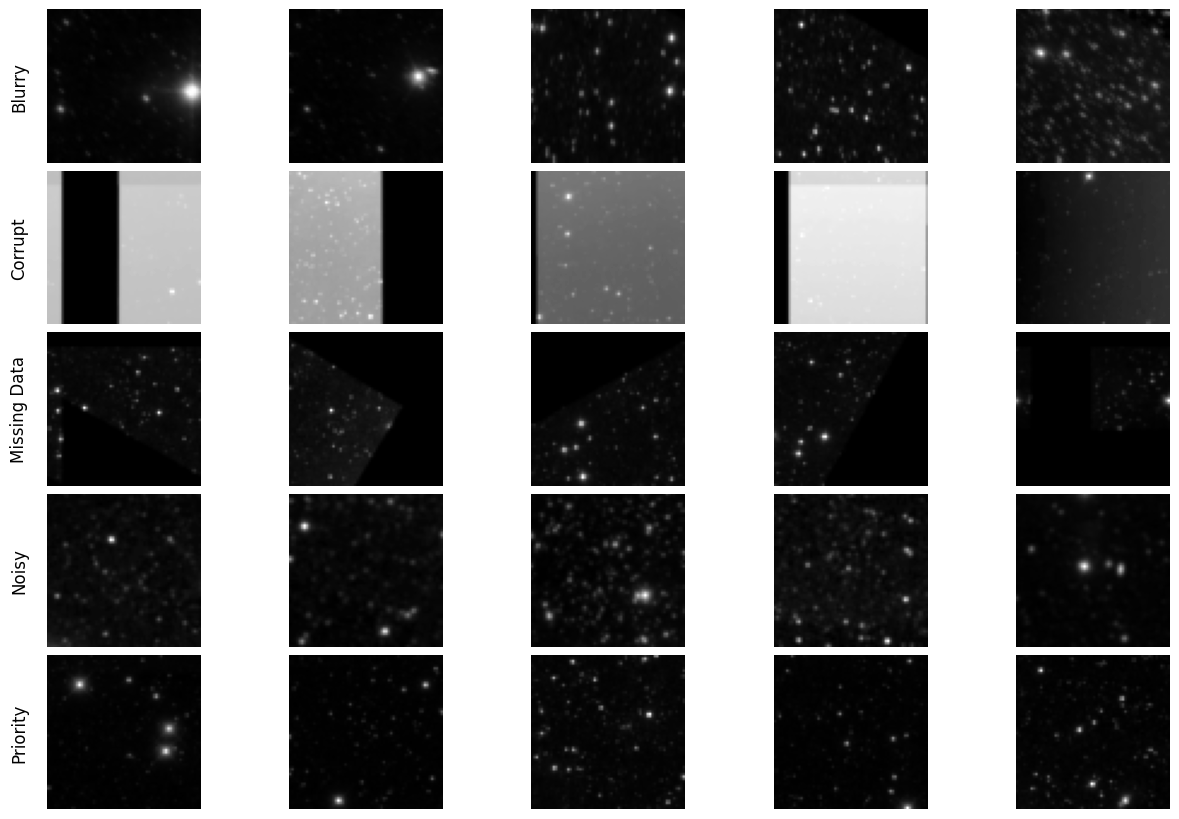

In [8]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure NumPy is imported

# Set the random seed for reproducibility
np.random.seed(42)

# Class names as a list
class_names = ['Blurry', 'Corrupt', 'Missing Data', 'Noisy', 'Priority']

# Number of images per class to display
num_images_per_class = 5

# Prepare the figure with appropriate size
fig, axes = plt.subplots(nrows=5, ncols=num_images_per_class, figsize=(15, 10))

for class_index, class_name in enumerate(class_names):
    # Get indices of images belonging to the current class
    indices = np.where(train_labels == class_index)[0]
    # Randomly select image indices using the fixed seed
    selected_indices = np.random.choice(indices, size=num_images_per_class, replace=False)
    for i, img_index in enumerate(selected_indices):
        # Get the corresponding image
        img = train_images_resized[img_index]
        # Access the appropriate axes
        ax = axes[class_index, i]
        # Display the image
        ax.imshow(img, cmap='gray')
        # Turn off axis ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        # Remove the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
    # Set the class label on the left of the row
    axes[class_index, 0].set_ylabel(class_name, rotation=90, size='large', labelpad=20, va='center')

# Adjust the subplot parameters to make room for the labels
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.05, hspace=0.05)

plt.show()

After reviewing the pre-processed images, it appears that reducing the size from 512x512 to 64x64 may not have been the best choice. Visually, it has become more challenging to distinguish between the **Priority**, **Noisy**, and **Blurry** categories. Now, let’s apply a machine learning method to classify these images.

---

## ML Classification

In [9]:
# First, let us Flatten the training images
num_train_samples = train_images_resized.shape[0]
train_images_flattened = train_images_resized.reshape(num_train_samples, -1)

### Train the Stochastic Gradient Descent (SGD) Model

The Stochastic Gradient Descent (SGD) model refers to algorithms that use the stochastic gradient descent optimization method to train machine learning models. The SGDClassifier is a powerful tool for training linear models efficiently, especially when dealing with large datasets. Its speed comes from updating model parameters incrementally using individual samples or small batches, significantly reducing the computational overhead per iteration compared to traditional gradient descent methods.

In [10]:
from sklearn.linear_model import SGDClassifier

# Create the stochastic gradient descent model

sgd_model = SGDClassifier( loss='log_loss', max_iter=10000, n_jobs=-1, random_state=42)

# Fit the model on the training data
sgd_model.fit(train_images_flattened, train_labels)

SGDClassifier(loss='log_loss', max_iter=10000, n_jobs=-1, random_state=42)

---

## Pipeline Evaluation

In this step, we are developing an evaluation startegy that aims to provide a comprehensive assessment of a given machine-learning pipeline by combining both performance metrics and resource usage metrics. Here’s what we’re trying to achieve:

1.	**Performance Metrics Evaluation**:
    - Accuracy and F1 Score: Measure the model’s ability to correctly classify images.
	- Confusion Matrix Analysis (optional): Identify specific classes where the model may be underperforming.
2.	**Resource Utilization Assessment**:
	- Evaluation Time: Determine the total time taken for preprocessing and prediction.
	- Pipeline Size: Calculate the combined size of the trained model and preprocessing steps to understand storage requirements.
	- Memory Consumption: Monitor peak memory usage during evaluation to ensure it fits within hardware constraints.
	- CPU Usage: Measure average CPU utilization to evaluate computational efficiency.

The primary objective is to not only achieve high classification accuracy but also to assess and optimize the pipeline’s computational efficiency and resource utilization. This holistic approach ensures that the model is not just effective but also practical for deployment, especially in environments with limited computational resources.


In [11]:
from source.pre import evaluate_pipeline # A built-in function to evaluate a given ML pipeline by preprocessing, predicting, and calculating performance metrics.

Inputs:

- **model**: The trained machine learning model to evaluate.
- **X_test_raw**: Raw test data that needs to be preprocessed before evaluation.
- **y_test**: True labels corresponding to the test data for performance comparison.
- **preprocessing_fn**: A function used to preprocess the raw test data.
    
Outputs:

- **metrics**: A dictionary containing various evaluation metrics like accuracy, F1 score, evaluation time, memory usage, CPU usage, and pipeline size.

### Preprocessing (Testing data)

By applying the same preprocessing to both the training and testing data, we ensure consistent feature representation, which is essential for accurate predictions and prevents errors from data mismatches. This alignment improves model evaluation and generalization to new data. Additionally, combining all preprocessing steps into a single function allows the evaluation function to track execution time and resource usage, ensuring both consistency and computational efficiency across the entire pipeline.

In [12]:
def preprocessing_fn(X):
    
    # Normalize the data to [0, 1]
    X_normalized = X.astype('float32') / 255.0
    
    # Convert to grayscale
    X_gray = np.array([rgb2gray(image) for image in X_normalized])
    
    # Resize images to 64x64 pixels
    X_resized = np.array([resize(image, (64, 64), anti_aliasing=True) for image in X_gray])
    
    # Flatten the images
    num_samples = X_resized.shape[0]
    X_flattened = X_resized.reshape(num_samples, -1)
    
    return X_flattened

### The Evaluation

In [13]:
# Assuming you have:
# - A trained model named 'lr_model'
# - Raw test data 'X_test_raw'
# - True labels 'y_test'
# - All pre-processing methods gathered in one function

# Evaluate the pipeline
metrics = evaluate_pipeline(sgd_model, val_images, val_labels, preprocessing_fn)

# Print the evaluation metrics
print("Evaluation Metrics:")
for key, value in metrics.items():
    if key == 'evaluation_time':
        print(f"{key}: {value:.2f} seconds")
    elif key == 'pipeline_size':
        print(f"{key}: {value:.2f} MB")
    elif key == 'peak_memory_usage':
        print(f"{key}: {value:.2f} MB")
    elif key == 'average_cpu_usage':
        print(f"{key}: {value:.2f}%")
    else:
        print(f"{key}: {value:.4f}")

(3237,)
(3237,)
Evaluation Metrics:
evaluation_time: 42.00 seconds
peak_memory_usage: 80379.66 MB
average_cpu_usage: 99.95%
accuracy: 0.4303
f1_score: 0.4069
pipeline_size: 0.08 MB


### Comparison with CubeCatNet CNN mdoel